# Реальная заработная плата в России
Федеральная служба государственной статистики ежемесячно оценивает среднюю реальную заработную плату в России; известны значения с января 1993 по январь 2017 (источник: [http://sophist.hse.ru/exes/tables/WAG_M.htm]. Необходимо построить прогноз на следующие три года.

In [5]:
import numpy as np
import pandas as pd

from dm_test import dm_test

from pmdarima import auto_arima

from scipy import stats
from scipy.special import inv_boxcox

from sklearn.metrics import mean_squared_error as mse

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing, HoltWintersResults

import pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = (16, 10)

In [6]:
data = pd.read_csv('monthly-wage.csv', sep=';', parse_dates=["Month"], index_col="Month")["Real wage"]

In [7]:
test = data.loc['2014-02':]
data = data.loc[:'2014-01']

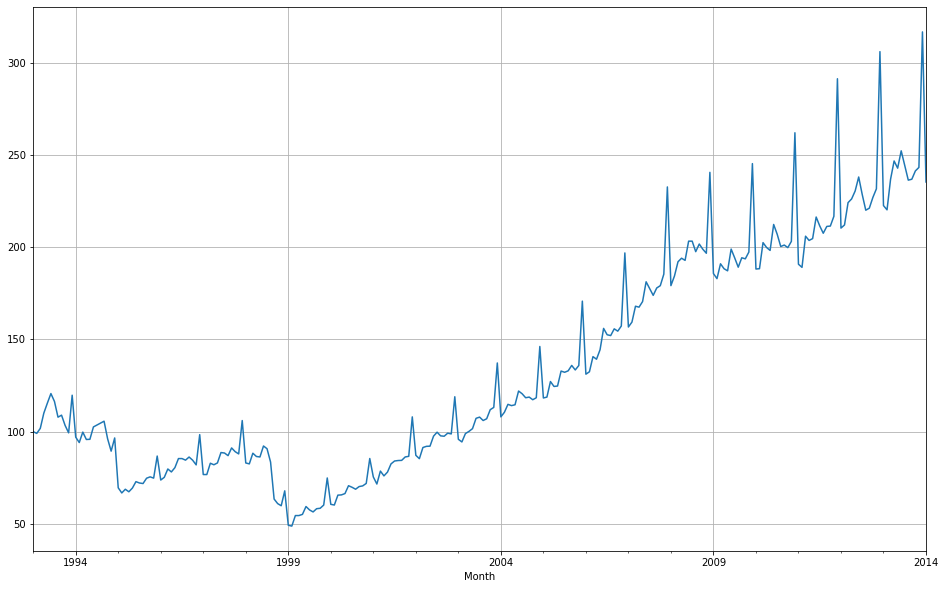

In [8]:
data.plot()
plt.grid()

Заметим, что в первые 5 лет признак ведёт себя и меняется не так, как в следующие годы; чтобы модель не перенастраивалась на неактуальные данные, будем рассматривать значения ряда только с января 1999.

In [9]:
data = data.loc['1999-01'::]

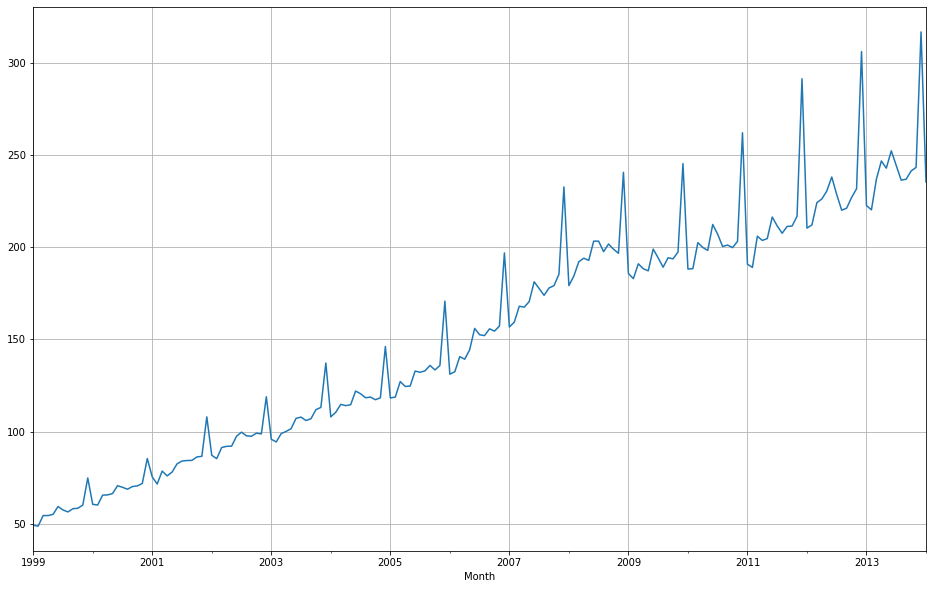

In [10]:
data.plot()
plt.grid()

Попробуем поделить на число дней в месяце:

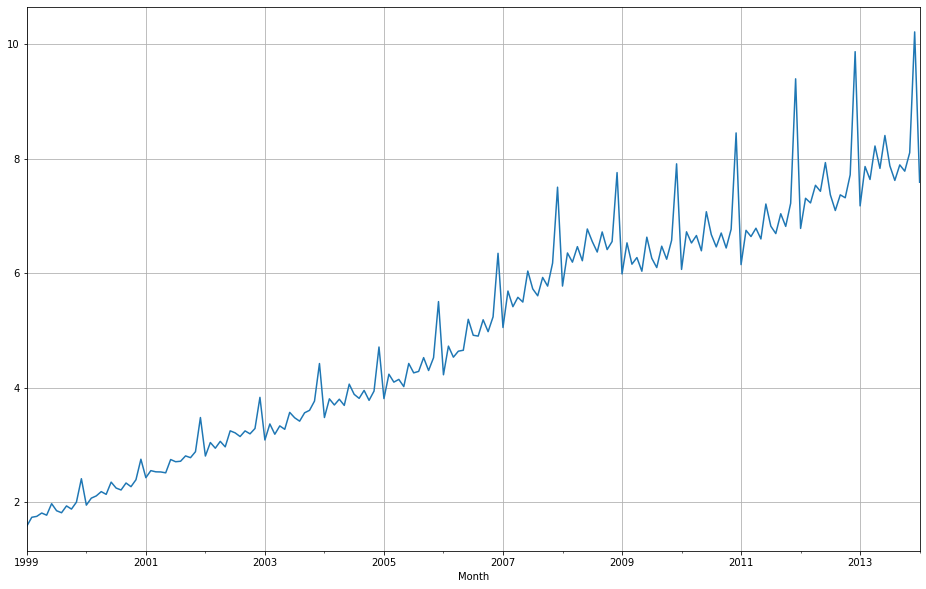

In [11]:
(data / data.index.days_in_month).plot()
plt.grid()

Ряд не стал более регулярным, так что вернёмся к исходным данным.

STL-декомпозиция ряда:

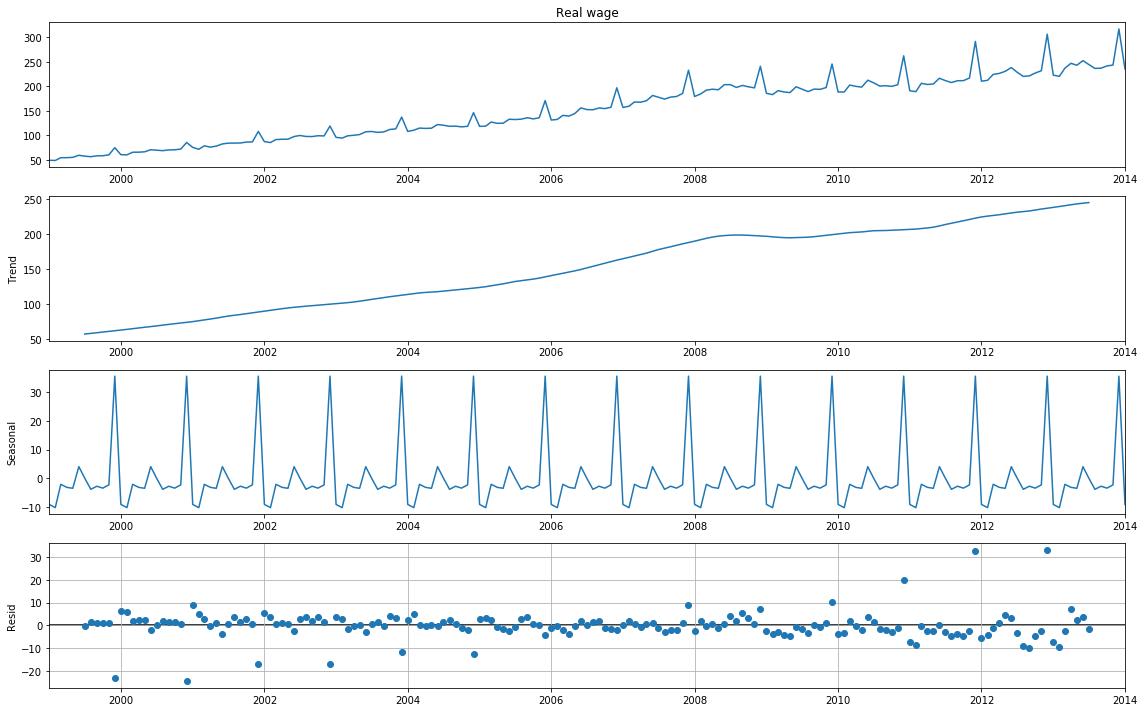

In [12]:
res = sm.tsa.seasonal_decompose(data)
res.plot()
plt.grid()

Оптимальное преобразование Бокса-Кокса и результат его применения:

In [14]:
print('Box-Cox transformation: lambda=%f' % stats.boxcox(data)[1])

Box-Cox transformation: lambda=0.627097


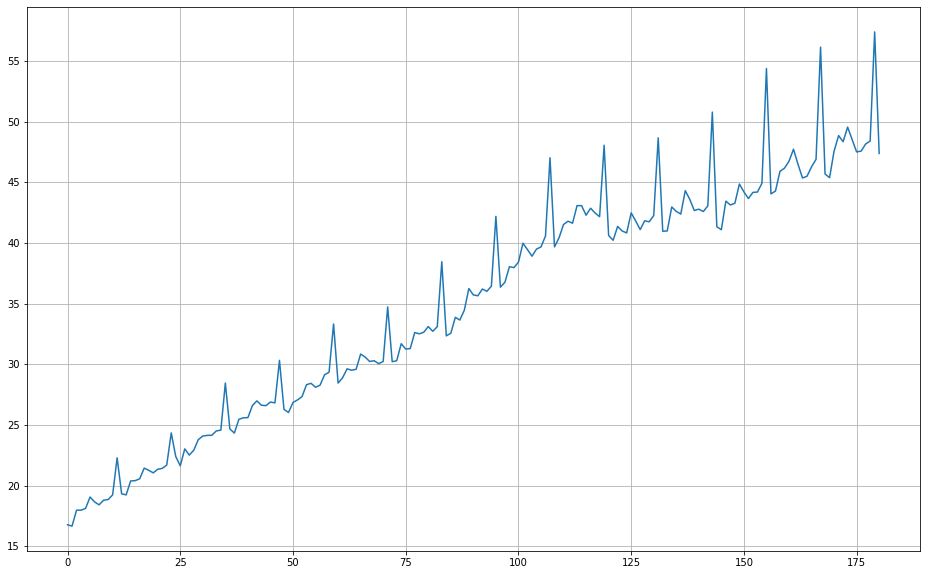

In [15]:
plt.plot(stats.boxcox(data)[0])
plt.grid()

В данном случае преобразование имеет смысл использовать, так как оно хорошо стабилизирует дисперсию. Попробуем округлить параметр и взять $\lambda=0$:

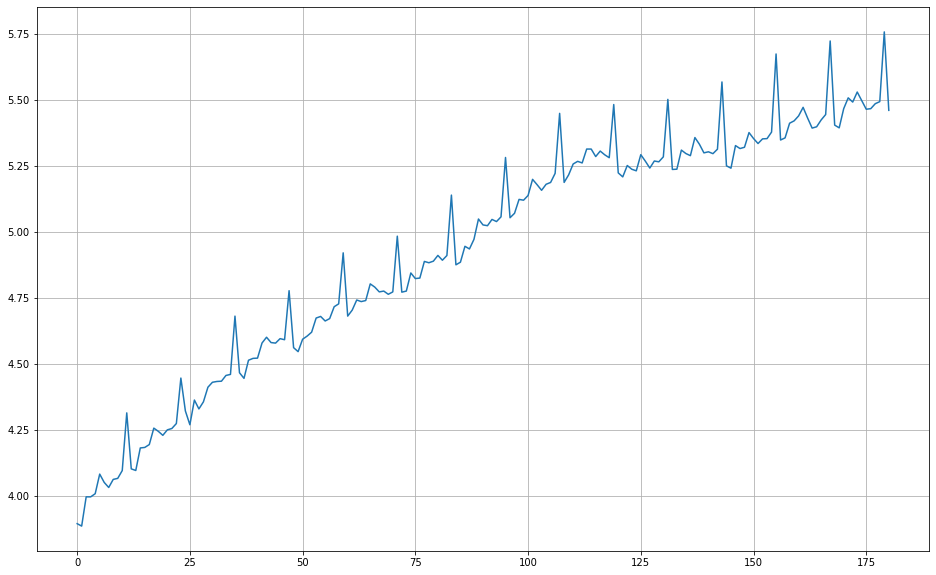

In [16]:
data_bc = stats.boxcox(data, lmbda=0.0)
plt.plot(data_bc)
plt.grid()

Результат лучше. Далее будем использовать $\lambda=0$.

## Прогноз ARIMA

In [17]:
stepwise_model = auto_arima(
    data_bc, start_p=0, start_q=0, m=12, seasonal=True,
    trace=True, error_action='ignore', suppress_warnings=True, stepwise=True
)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=-826.008, BIC=-813.512, Time=1.562 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-803.300, BIC=-797.052, Time=0.105 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-835.503, BIC=-823.007, Time=1.507 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-839.596, BIC=-827.100, Time=0.781 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-805.015, BIC=-801.891, Time=0.035 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-813.241, BIC=-803.869, Time=0.465 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-838.049, BIC=-822.430, Time=1.595 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=-837.952, BIC=-822.332, Time=2.718 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=-834.698, BIC=-822.202, Time=1.376 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=-835.642,

In [18]:
auto_arima_params = stepwise_model.get_params()
print('Proposed ARIMA', 
      auto_arima_params['order'], 
      auto_arima_params['seasonal_order'],
      ' AIC:', stepwise_model.aic(),
      ', BIC:',stepwise_model.bic())

Proposed ARIMA (1, 1, 0) (0, 1, 1, 12)  AIC: -840.3389866252892 , BIC: -827.8431307076761


Посмотрим на остатки модели:

In [19]:
fit_auto_arima = stepwise_model.fit(data_bc)
res_auto_arima = fit_auto_arima.resid()

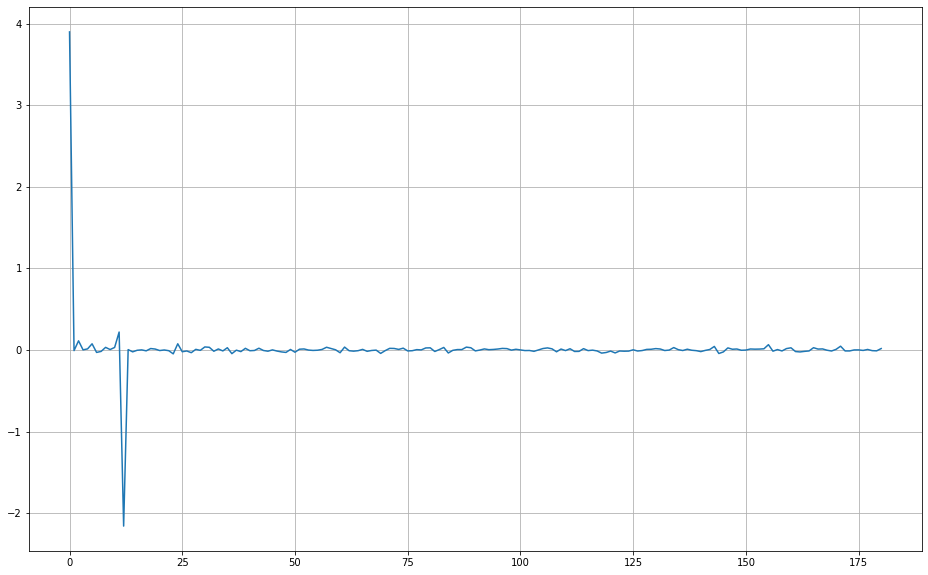

In [21]:
plt.plot(res_auto_arima);
plt.grid()

Отрежем первые 13 отсчётов и продолжим анализ:

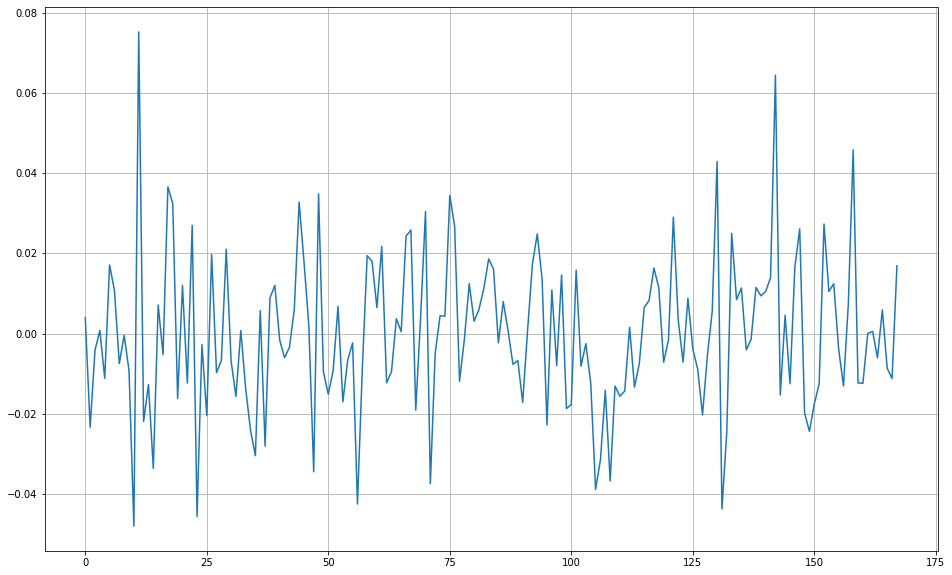

In [22]:
plt.plot(res_auto_arima[13:])
plt.grid()

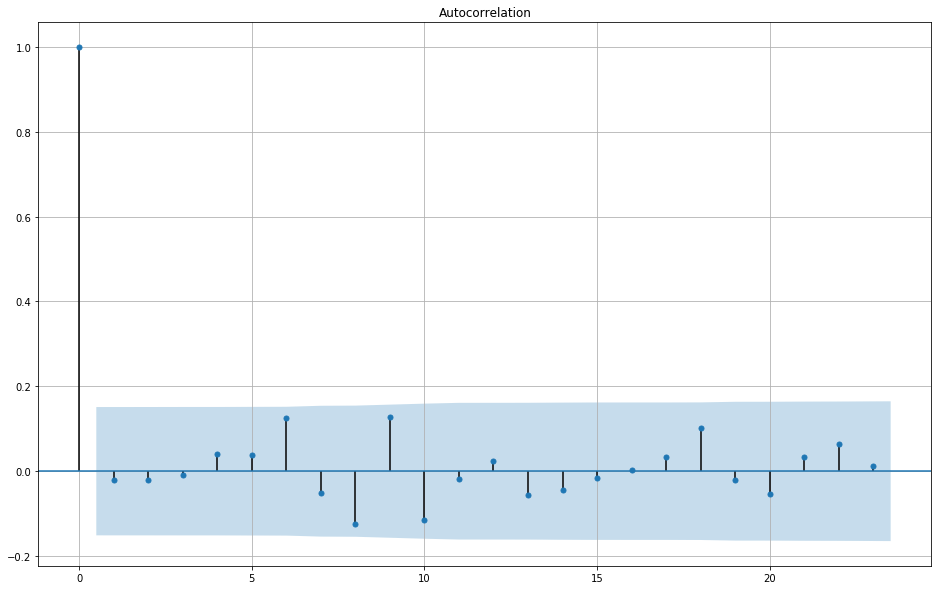

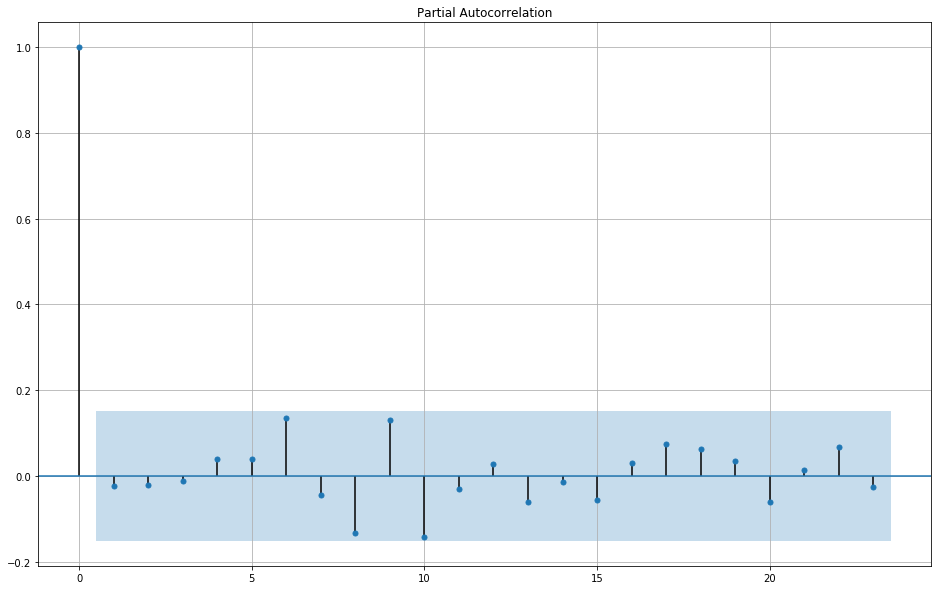

In [88]:
sm.graphics.tsa.plot_acf(res_auto_arima[13:]); plt.grid()
sm.graphics.tsa.plot_pacf(res_auto_arima[13:]); plt.grid()

In [24]:
lb_pvalue = sm.stats.acorr_ljungbox(res_auto_arima[13:], lags=12*3, boxpierce=True, return_df = True)['lb_pvalue']

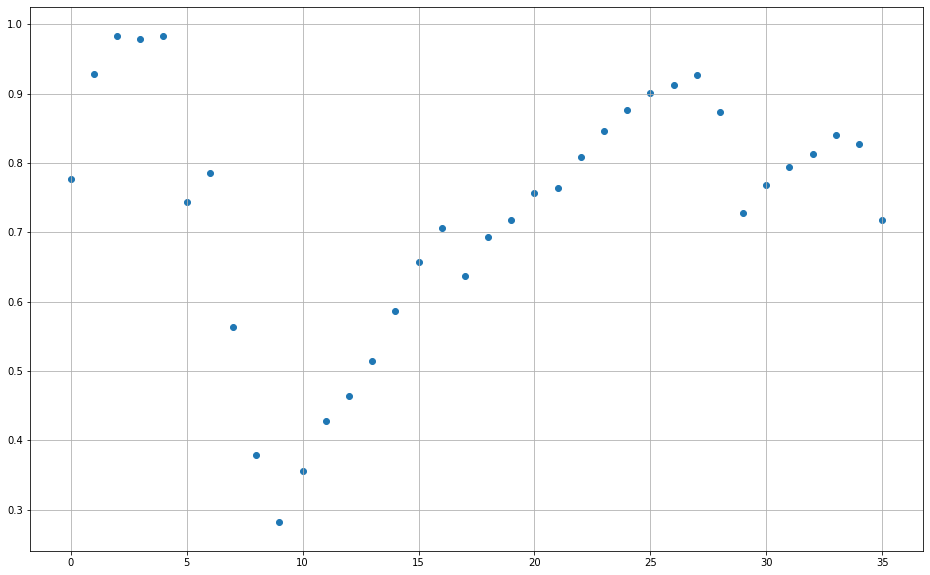

In [25]:
plt.scatter(range(len(lb_pvalue)), lb_pvalue)
plt.grid()

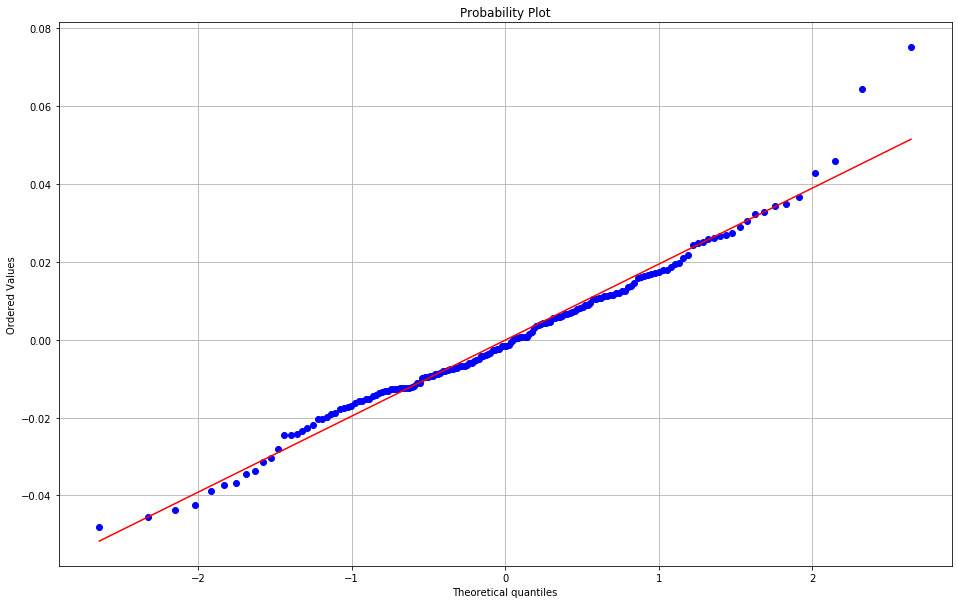

In [26]:
stats.probplot(res_auto_arima[13:], dist="norm", plot=pylab)
plt.grid()

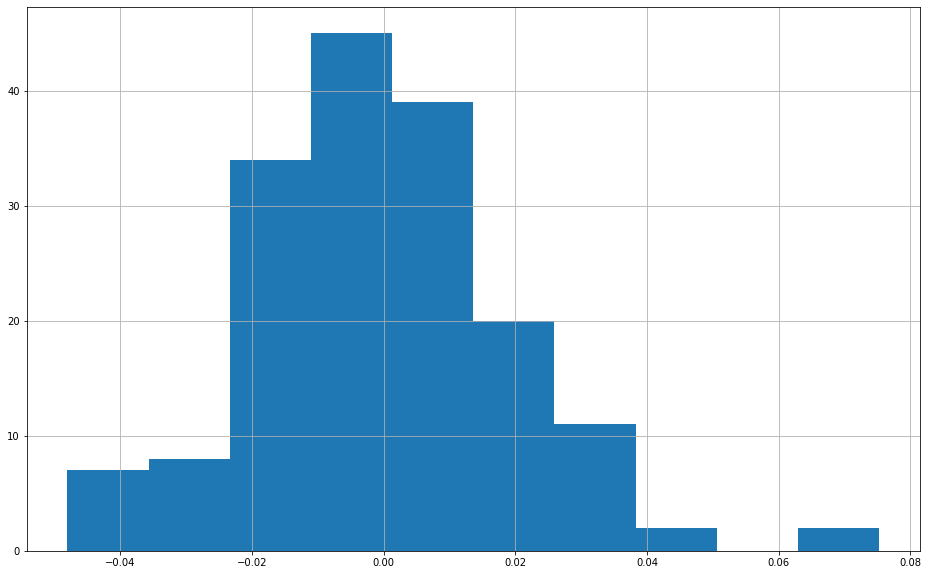

In [27]:
plt.hist(res_auto_arima[13:])
plt.grid()

In [44]:
def _check(pvalue, alpha=0.05):
    return 'отвергается' if pvalue < alpha else 'не отвергается', pvalue

table_hypothesis = pd.DataFrame([
    ['Нормальность', 'Шапиро-Уилка', *_check(stats.shapiro(res_auto_arima[13:])[1])],
    ['Несмещённость', 'Уилкоксона', *_check(stats.wilcoxon(res_auto_arima[13:])[1])],
    ['Стационарность', 'KPSS', *_check(sm.tsa.stattools.kpss(res_auto_arima[13:], nlags='auto')[1])]
])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 'Достигаемый уровень значимости']
table_hypothesis

c:\program files\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,отвергается,0.021414
1,Несмещённость,Уилкоксона,не отвергается,0.674705
2,Стационарность,KPSS,не отвергается,0.100000


## Ручной подбор модели

In [47]:
sm.tsa.stattools.kpss(data_bc, nlags='auto')[1]

c:\program files\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


0.01

In [48]:
def difference(dataset, interval=1):
    return dataset[interval:] - dataset[:-interval]

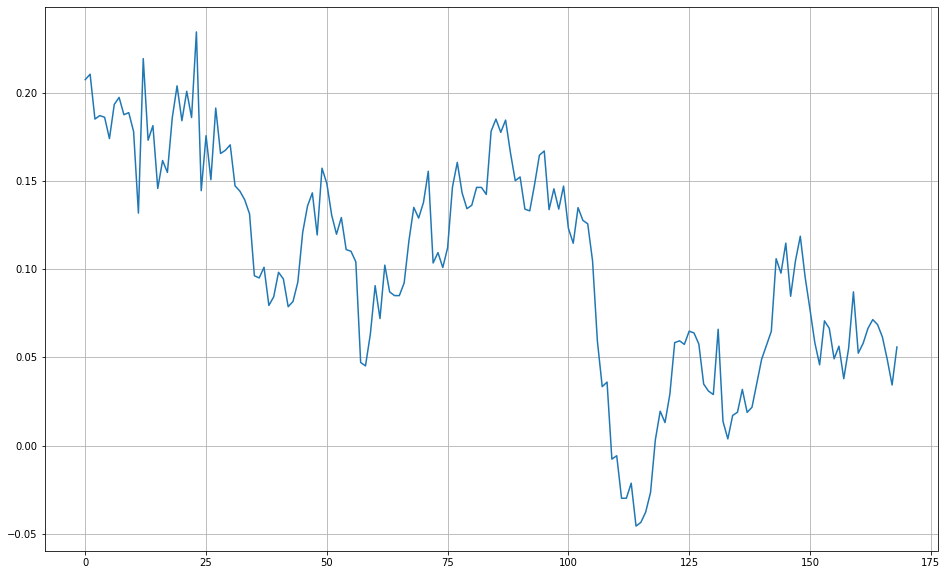

In [49]:
diff_data = difference(data_bc, 12)
plt.plot(diff_data)
plt.grid()

In [50]:
sm.tsa.stattools.kpss(diff_data, nlags='auto')[1]

c:\program files\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


0.01

Ряд всё ещё нестационарен (p<0.01, критерий KPSS). Проведём ещё одно дифференцирование:

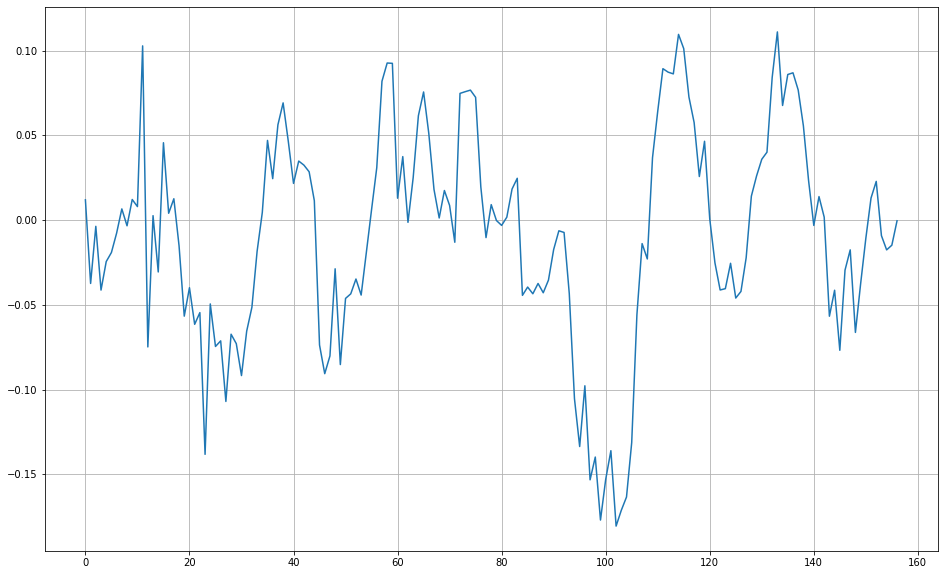

In [51]:
diff2_data = difference(diff_data, 12)
plt.plot(diff2_data)
plt.grid()

In [52]:
sm.tsa.stattools.kpss(diff2_data, nlags='auto')[1]

c:\program files\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


0.1

Для полученного ряда гипотеза стационарности не отвергается ($p > 0.1$)

Посмотрим на ACF и PACF полученного продифференцированного ряда:

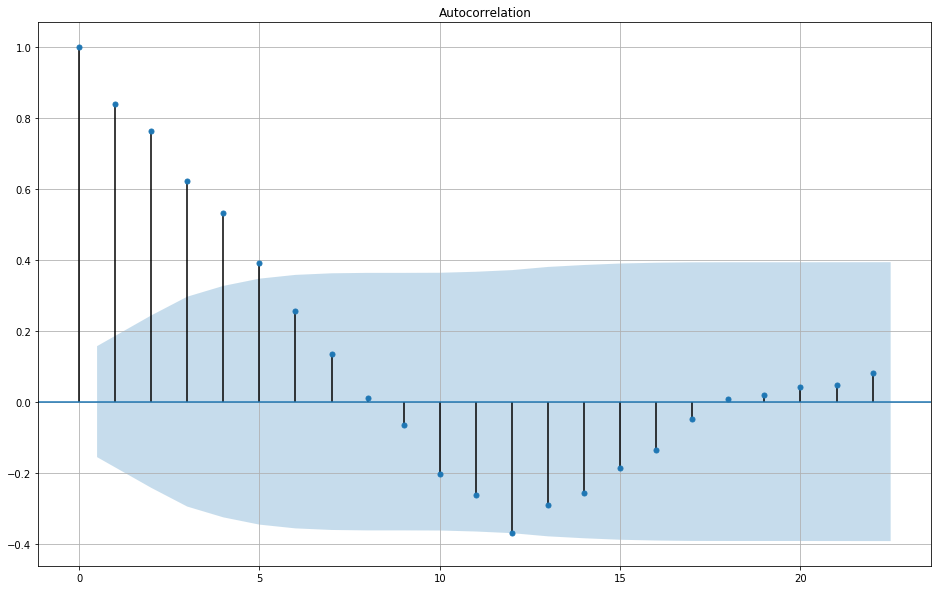

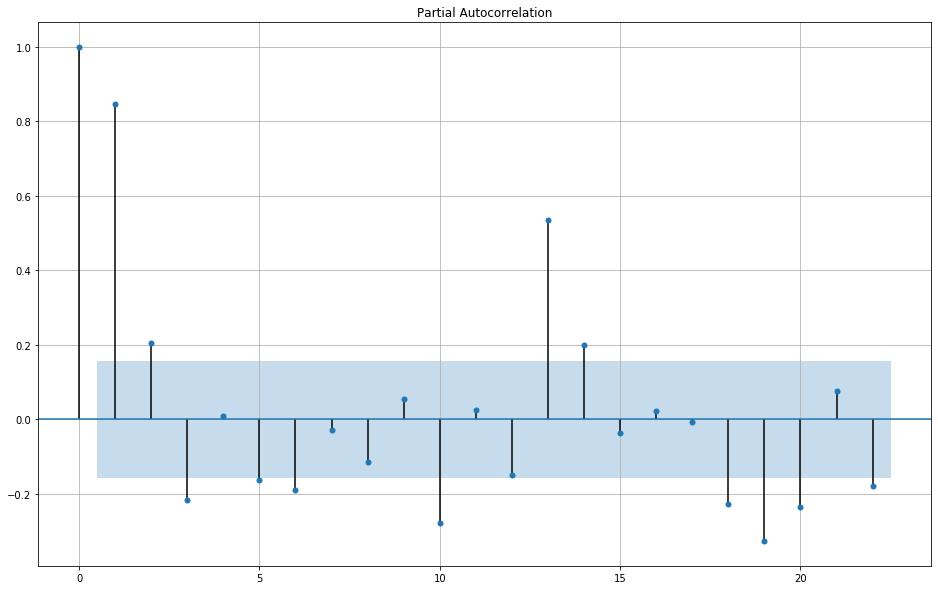

In [54]:
diff2_data = pd.DataFrame(diff2_data)
sm.graphics.tsa.plot_acf(diff2_data); plt.grid()
sm.graphics.tsa.plot_pacf(diff2_data); plt.grid()

На ACF значимы лаги 1, 2, 3, 4, 5, более того график выглядит как синусоида, на PACF — 1, 2, 3, 5, 6, 10, 13, 14, 18, 19, 20, 22. Поищем с помощью auto.arima оптимальную модель полным перебором (stepwise=FALSE) с ограничениями d=1, D=1, max.p=6, max.q=0, max.P=3, max.Q=3, max.order=6:

In [55]:
model_arima = auto_arima(
    data_bc, start_p=1, start_q=0, max_p=6, max_q=0, max_P=3, max_Q=5, m=12, max_order=6,
    seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=False
)

Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-803.300, BIC=-797.052, Time=0.136 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=-827.693, BIC=-818.321, Time=0.500 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 2, 12) (constant=True); AIC=-825.915, BIC=-813.419, Time=1.998 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 3, 12) (constant=True); AIC=-826.587, BIC=-810.967, Time=5.780 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 4, 12) (constant=True); AIC=-828.548, BIC=-809.805, Time=12.844 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 5, 12) (constant=True); AIC=-827.025, BIC=-805.157, Time=44.174 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-824.032, BIC=-814.660, Time=0.889 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=-826.008, BIC=-813.512, Time=1.491 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 2, 12) (constant=True); AIC=-823.695, BIC=-808.075, Time=2.608 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 3, 12) (constant=True); AIC=-826.328, BIC=-807.584, Time=9.964 seconds
Fit ARIM

In [56]:
model_arima_params = model_arima.get_params()
print('Proposed ARIMA', 
      model_arima_params['order'], 
      model_arima_params['seasonal_order'],
      ' AIC:', model_arima.aic(),
      ', BIC:',model_arima.bic())

Proposed ARIMA (1, 1, 0) (3, 1, 0, 12)  AIC: -841.1599418782178 , BIC: -822.4161580017982


In [57]:
model_arima_fit = model_arima.fit(data_bc)

Посмотрим на остатки модели:

In [58]:
res_arima = model_arima_fit.resid()

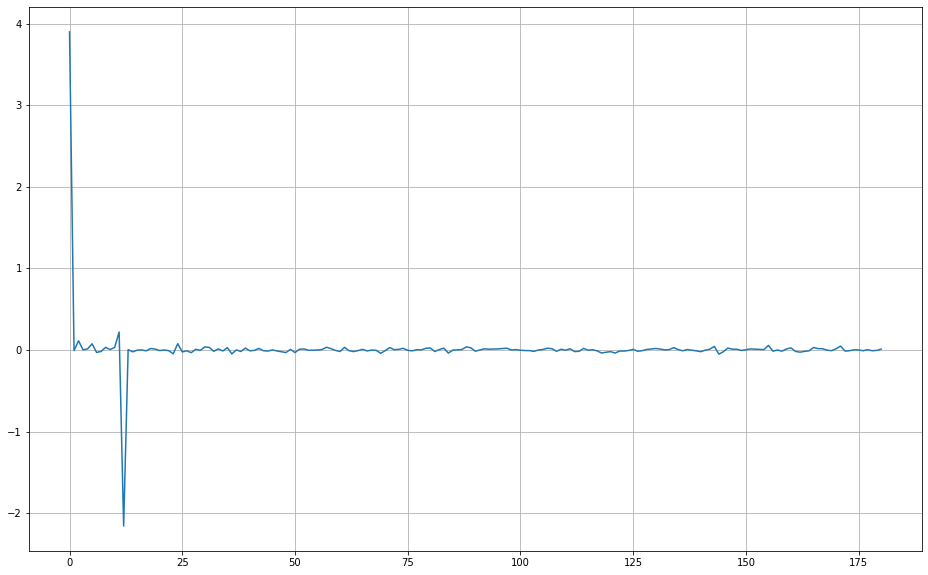

In [59]:
plt.plot(res_arima)
plt.grid()

Отрежем первые 13 отсчётов и продолжим анализ:

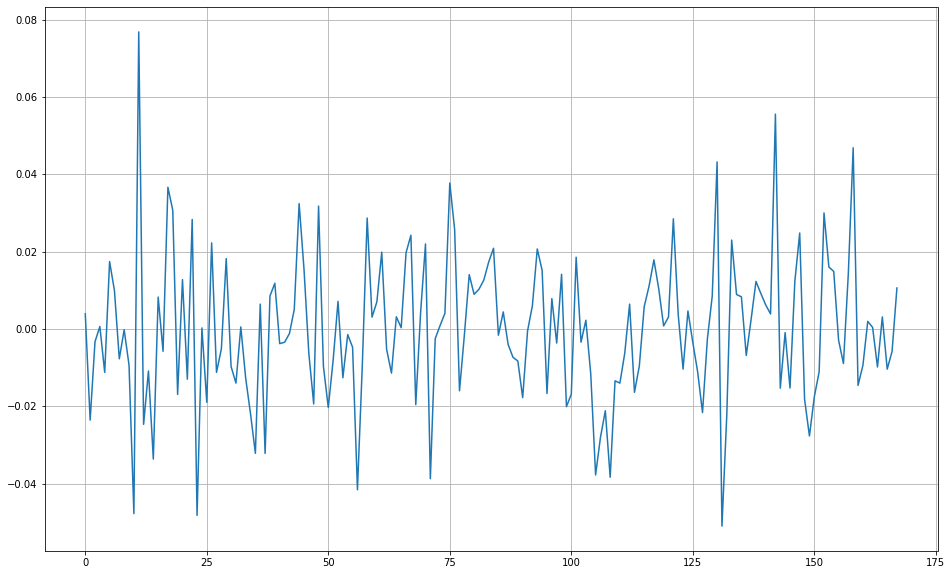

In [60]:
plt.plot(res_arima[13:])
plt.grid()

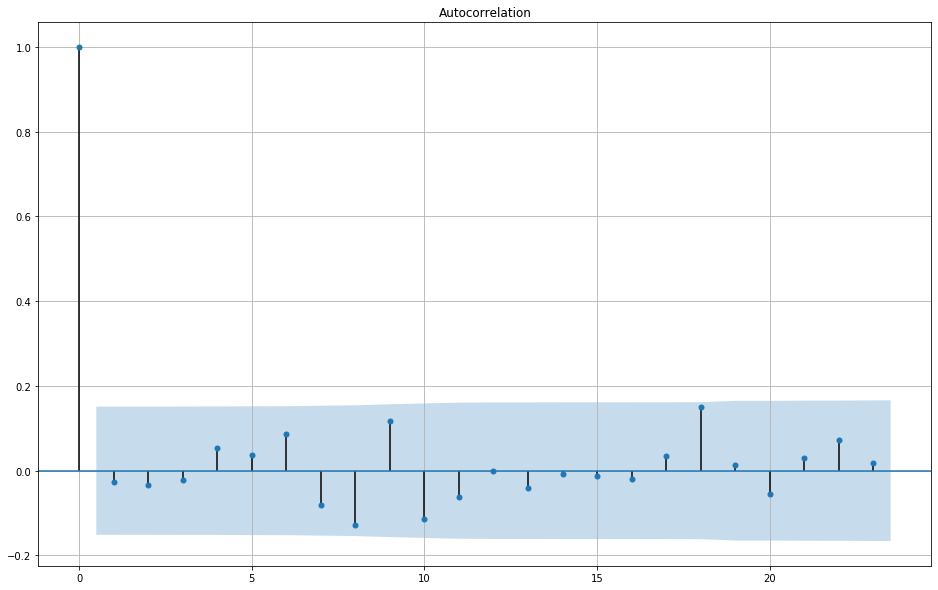

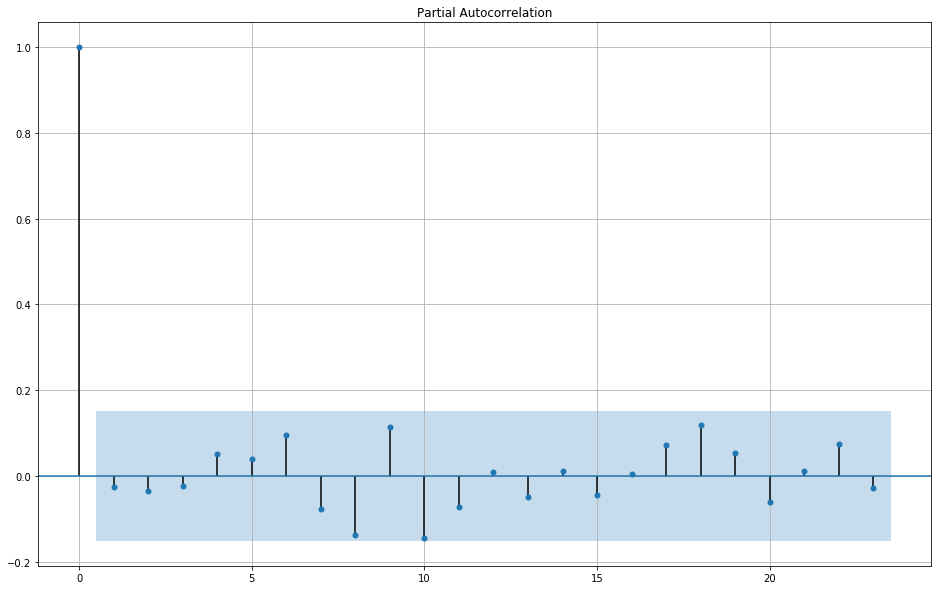

In [61]:
sm.graphics.tsa.plot_acf(res_arima[13:]); plt.grid()
sm.graphics.tsa.plot_pacf(res_arima[13:]); plt.grid()

In [62]:
lb_pvalue = sm.stats.acorr_ljungbox(res_arima[13:], lags=12*3, boxpierce=True, return_df = True)['lb_pvalue']

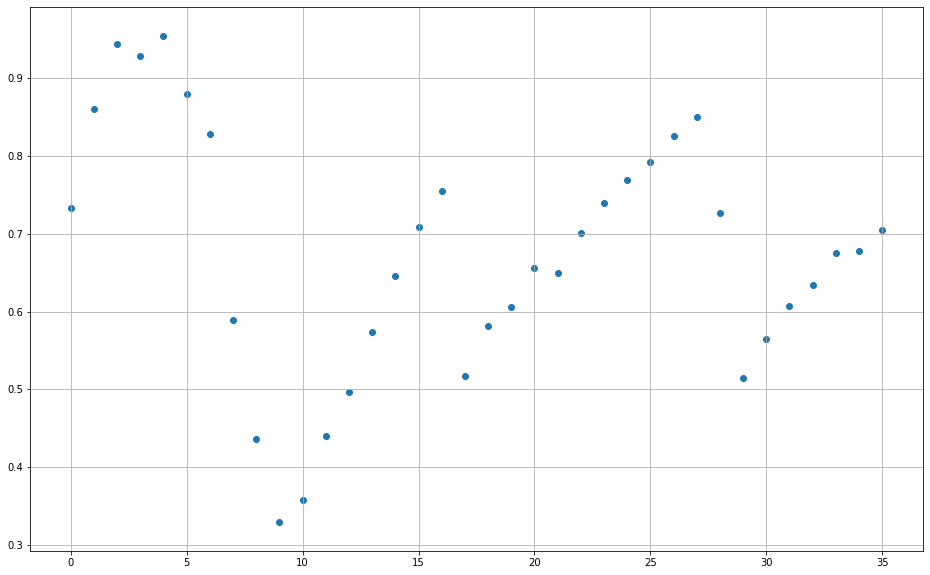

In [63]:
plt.scatter(range(len(lb_pvalue)), lb_pvalue)
plt.grid()

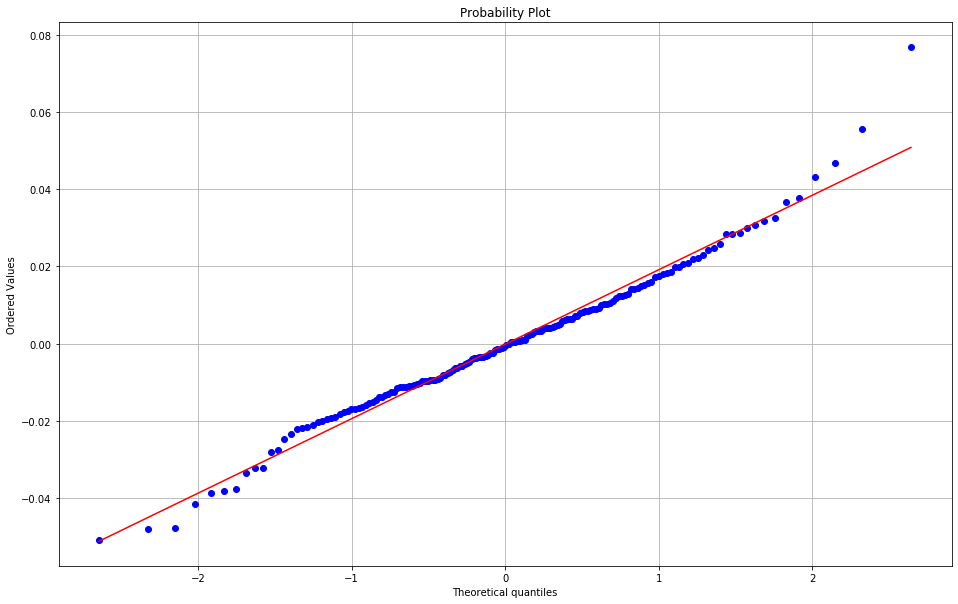

In [64]:
stats.probplot(res_arima[13:], dist="norm", plot=pylab)
plt.grid()

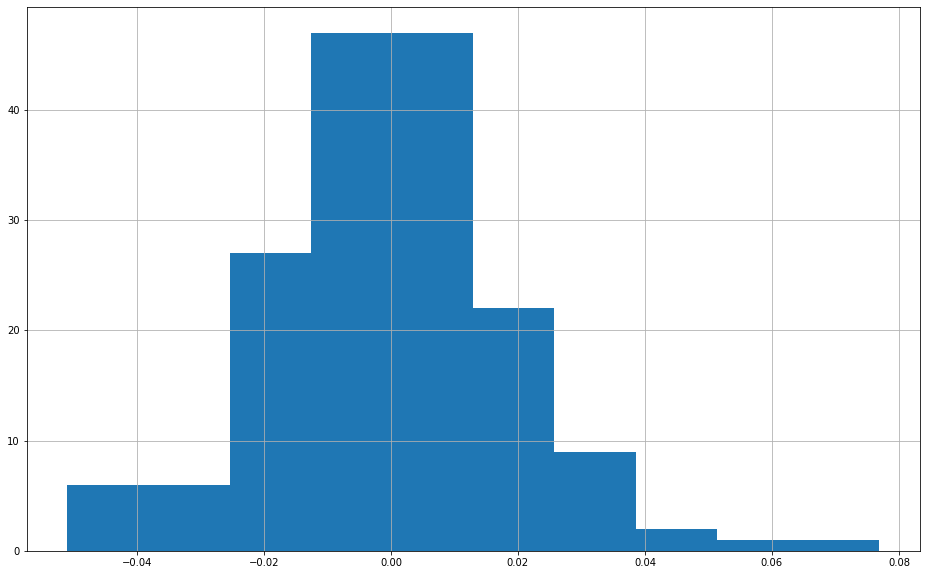

In [65]:
plt.hist(res_arima[13:])
plt.grid()

In [66]:
table_hypothesis = pd.DataFrame([
    ['Нормальность', 'Шапиро-Уилка', *_check(stats.shapiro(res_arima[13:])[1])],
    ['Несмещённость', 'Уилкоксона', *_check(stats.wilcoxon(res_arima[13:])[1])],
    ['Стационарность', 'KPSS', *_check(sm.tsa.stattools.kpss(res_arima[13:], nlags='auto')[1])]
])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 'Достигаемый уровень значимости']
table_hypothesis

c:\program files\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,отвергается,0.030899
1,Несмещённость,Уилкоксона,не отвергается,0.700344
2,Стационарность,KPSS,не отвергается,0.100000


In [67]:
model_arima_pred = inv_boxcox(model_arima_fit.predict(n_periods=len(test)), 0)
auto_arima_pred = inv_boxcox(fit_auto_arima.predict(n_periods=len(test)), 0)

In [68]:
model_arima_pred, arima_conf_int = model_arima_fit.predict(
    n_periods=len(test), return_conf_int=True, alpha=0.01
)
auto_arima_pred, auto_arima_conf_int = fit_auto_arima.predict(
    n_periods=len(test), return_conf_int=True, alpha=0.01
)

In [69]:
model_arima_pred = inv_boxcox( model_arima_pred, 0)
auto_arima_pred = inv_boxcox(auto_arima_pred, 0)
arima_conf_int = inv_boxcox(arima_conf_int, 0)
auto_arima_conf_int = inv_boxcox(auto_arima_conf_int, 0)

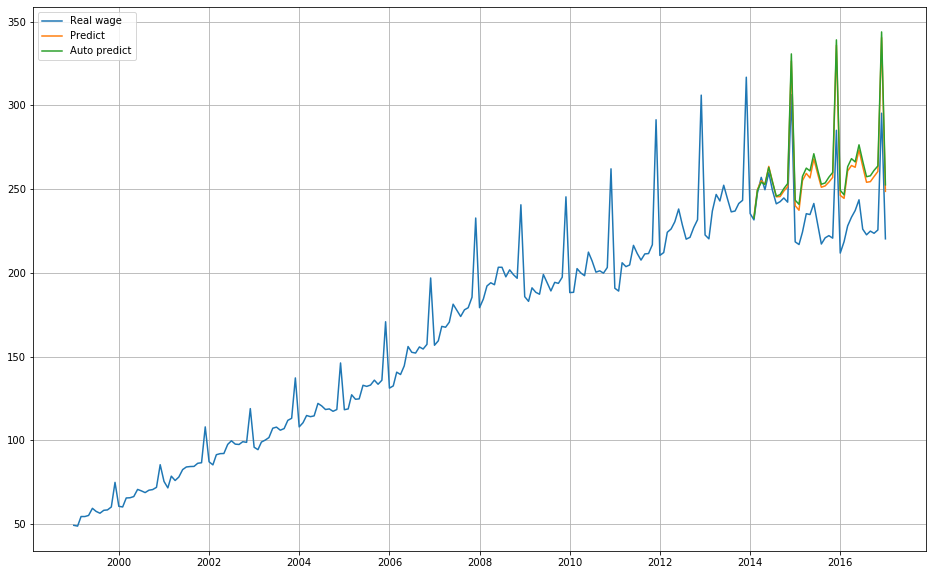

In [70]:
plt.plot(data.append(test), label = 'Real wage')
plt.plot(test.index, model_arima_pred, label = 'Predict')
plt.plot(test.index, auto_arima_pred, label = 'Auto predict')
plt.legend()
plt.grid()

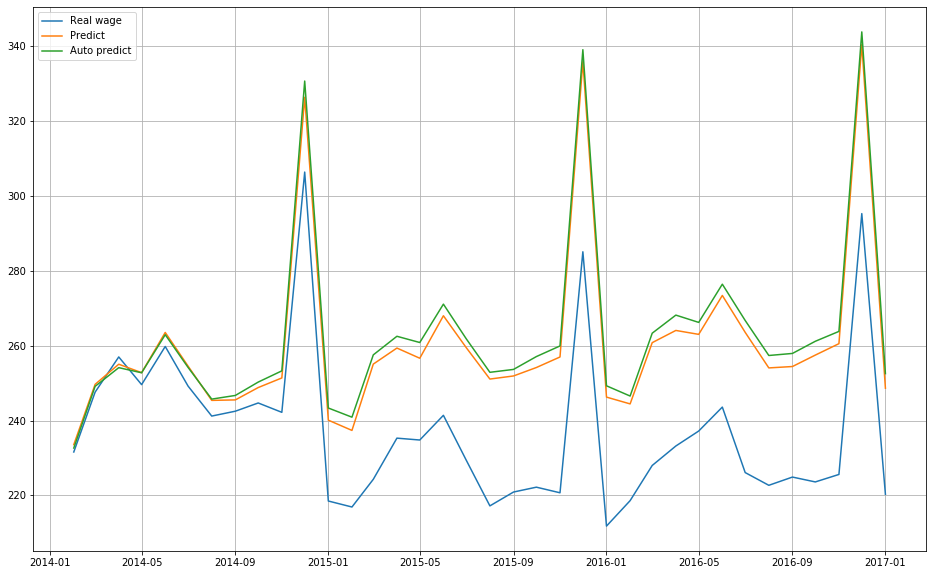

In [71]:
plt.plot(test, label = 'Real wage')
plt.plot(test.index, model_arima_pred, label = 'Predict')
plt.plot(test.index, auto_arima_pred, label = 'Auto predict')
plt.legend()
plt.grid()

В целом подобранная вручную модель сложнее, а её остатки не лучше.

# Прогноз ETS

Для примера рассмотрим настройку метода ExponentialSmoothing на основе критерия AIC.
https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/   
При сравнении различных методов экспоненциального сглаживания можно использовать следующую методику:
https://www.researchgate.net/publication/222552350_A_State_Space_Framework_for_Automatic_Forecasting_Using_Exponential_Smoothing_Methods

In [72]:
from itertools import product

def exp_smoothing_configs():
    models = []
    
    t_params = ['add', 'mul']
    d_params = [True, False]
    s_params = ['add', 'mul']
    
    p = [12]
    b = ['log']
    
    r_params = [True, False]
    sl_params = np.arange(0, 1, 0.2)
    ssl_params = np.arange(0, 1, 0.2)
    sse_params = np.arange(0, 1, 0.2)
    ds_params = np.arange(0, 1, 0.2)
    
    models = list(product(
        t_params, d_params, s_params, p, b, r_params, 
        sl_params, ssl_params, sse_params, ds_params
    ))
    
    return models

In [73]:
def exp_smoothing_forecast(history, len_test, config):
    t,d,s,p,b,r,sl,ssl,sse,ds = config
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    model_fit = model.fit(
        use_boxcox=b, remove_bias=r, smoothing_level=sl, 
        smoothing_slope=ssl, smoothing_seasonal=sse, damping_slope=ds
    )
    pred = model_fit.forecast(len_test)
    res = model_fit.resid
    aic = model_fit.aic
    return pred,res,aic

In [74]:
cfg_list = exp_smoothing_configs()

In [75]:
predict_ets = []
aic_max = 10000
for cfg in cfg_list:
    predict, res, aic = exp_smoothing_forecast(data, len(test), cfg)
    if (aic < aic_max):
        aic_max = aic
        res_ets = res
        predict_ets = predict

c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:952: RuntimeWarning: divide by zero encountered in true_divide
  season = (fitted / inv_boxcox(trend, lamda))[:nobs]
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:952: RuntimeWarning: overflow encountered in true_divide
  season = (fitted / inv_boxcox(trend, lamda))[:nobs]
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to co

c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converg

c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converg

c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\program files\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converg

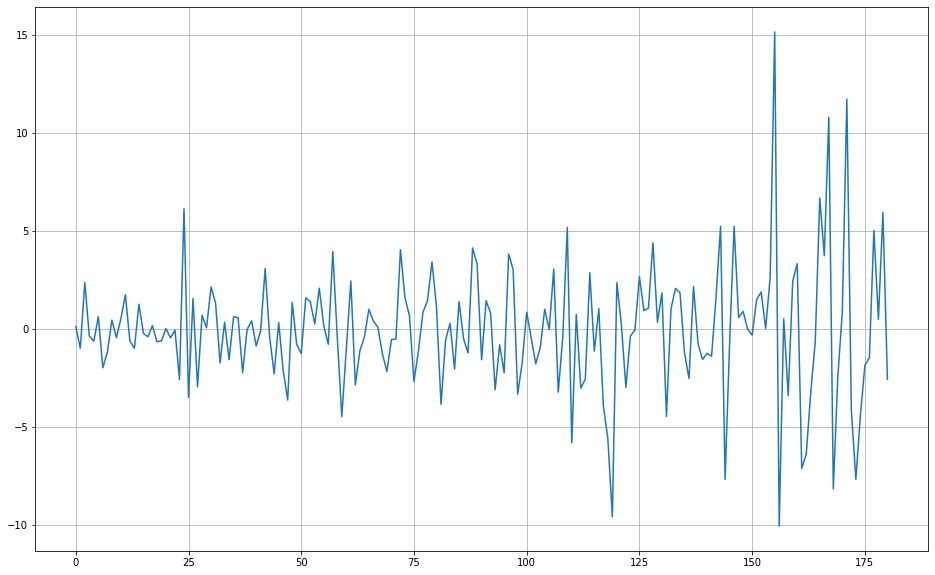

In [76]:
plt.plot(res_ets)
plt.grid()

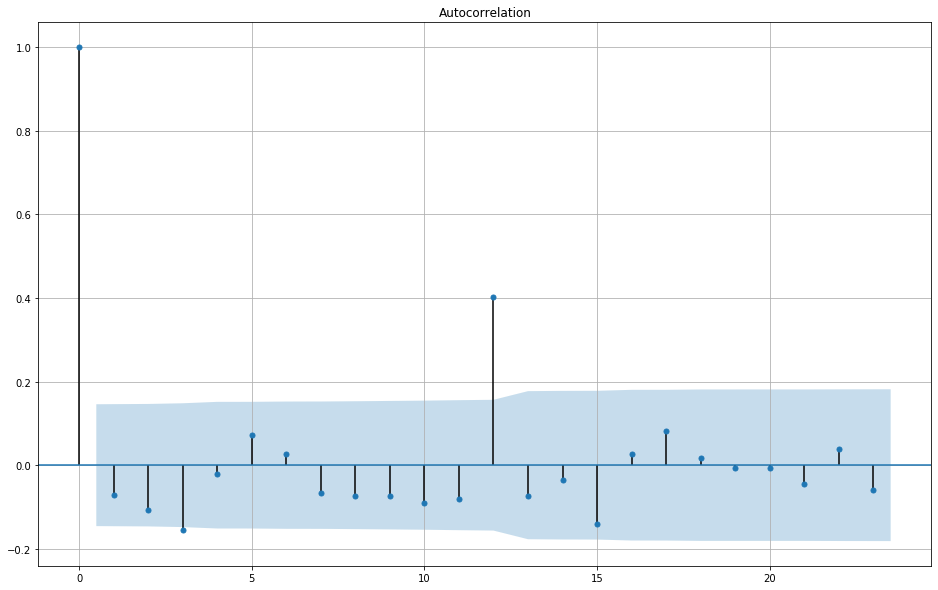

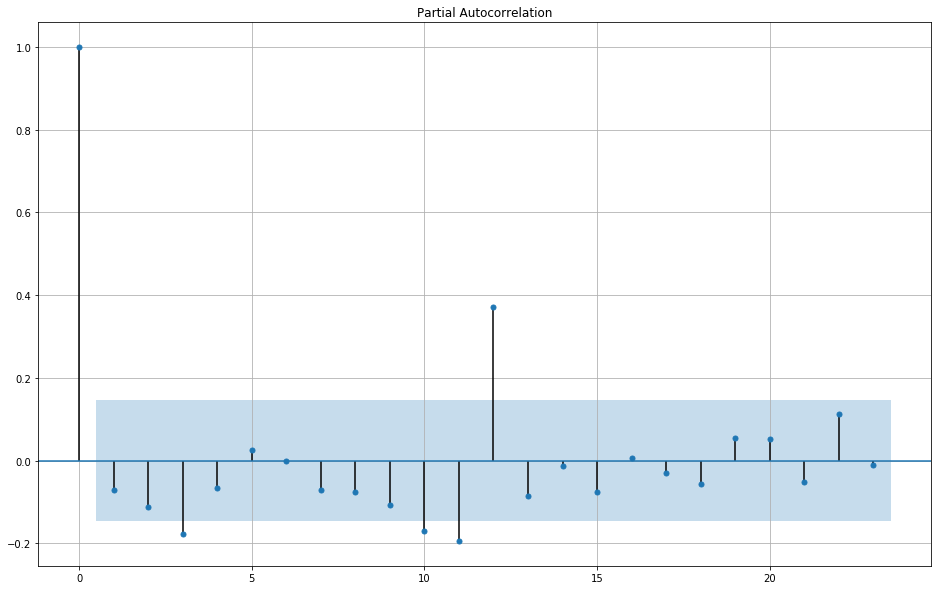

In [77]:
sm.graphics.tsa.plot_acf(res_ets); plt.grid()
sm.graphics.tsa.plot_pacf(res_ets); plt.grid()

In [78]:
lb_pvalue = sm.stats.acorr_ljungbox(res_ets, lags=12*3, boxpierce=True, return_df=True)['lb_pvalue']

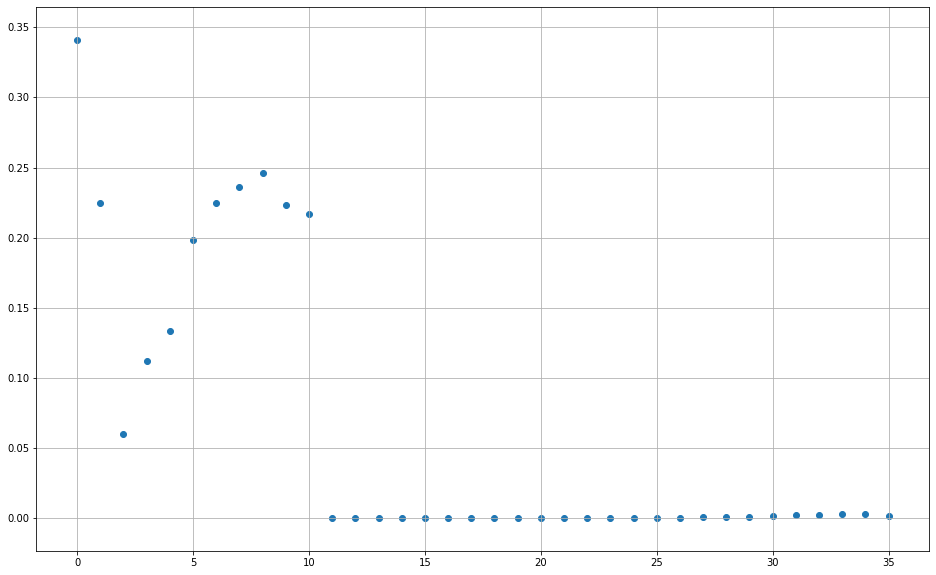

In [79]:
plt.scatter(range(len(lb_pvalue)), lb_pvalue)
plt.grid()

Остатки коррелированы, по всей видимости, модель недостаточно хороша.

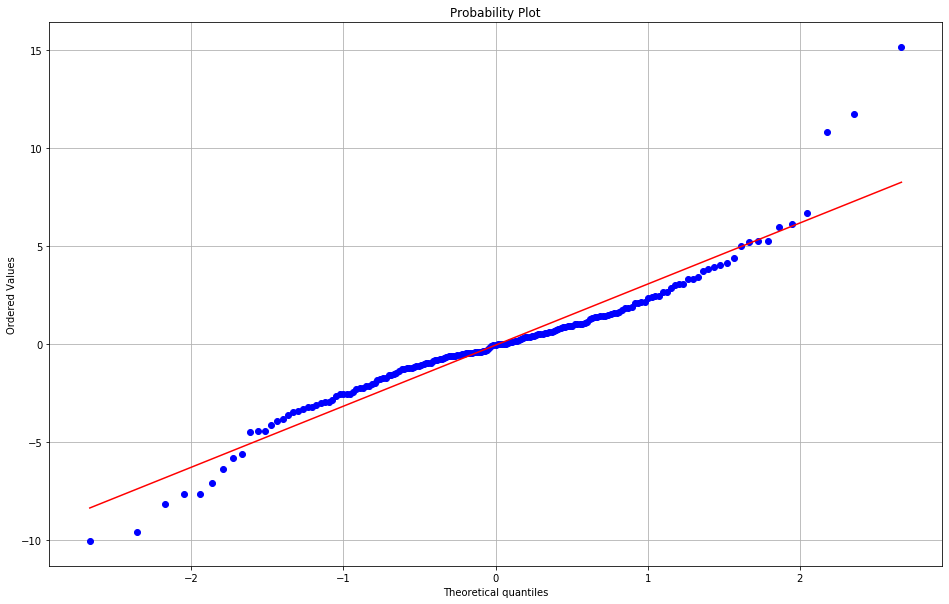

In [80]:
stats.probplot(res_ets, dist="norm", plot=pylab)
plt.grid()

Распределение имеет длинные хвосты и выбросы справа.

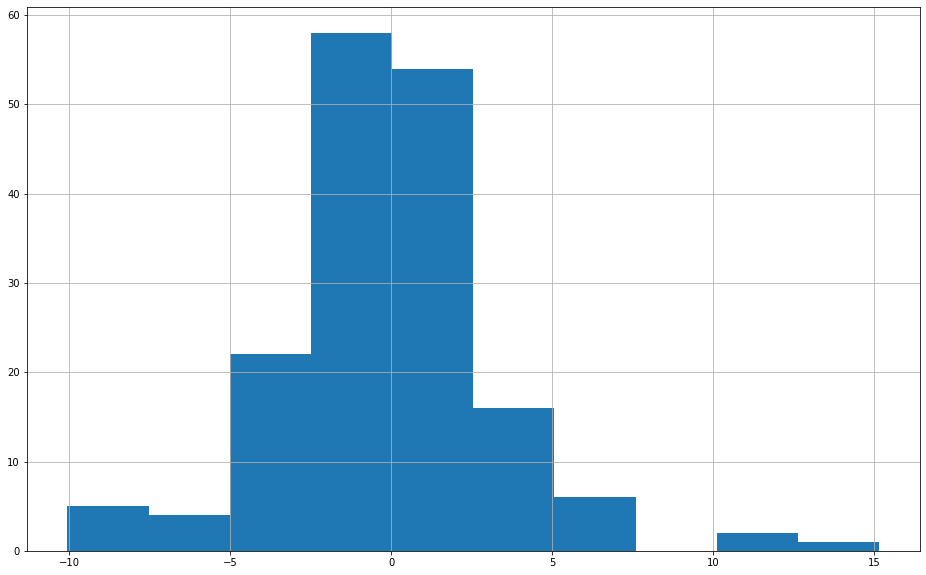

In [81]:
plt.hist(res_ets[13:])
plt.grid()

In [83]:
table_hypothesis = pd.DataFrame([
    ['Нормальность', 'Шапиро-Уилка', *_check(stats.shapiro(res_ets)[1])],
    ['Несмещённость', 'Уилкоксона', *_check(stats.wilcoxon(res_ets)[1])],
    ['Стационарность', 'KPSS', *_check(sm.tsa.stattools.kpss(res_ets, nlags='auto')[1])]
])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки', 'Достигаемый уровень значимости']
table_hypothesis

c:\program files\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,отвергается,1.034664e-07
1,Несмещённость,Уилкоксона,не отвергается,6.095474e-01
2,Стационарность,KPSS,не отвергается,1.000000e-01


## Сравнение моделей

In [84]:
dm_test(test,auto_arima_pred, model_arima_pred)

dm_return(DM=8.690442903039251, p_value=2.9168673321814433e-10)

In [85]:
dm_test(test,predict_ets, model_arima_pred)

dm_return(DM=6.440973666013231, p_value=2.0357157129650994e-07)

Критерий Диболда-Мариано не обнаруживает значимого различия между качеством прогнозов.

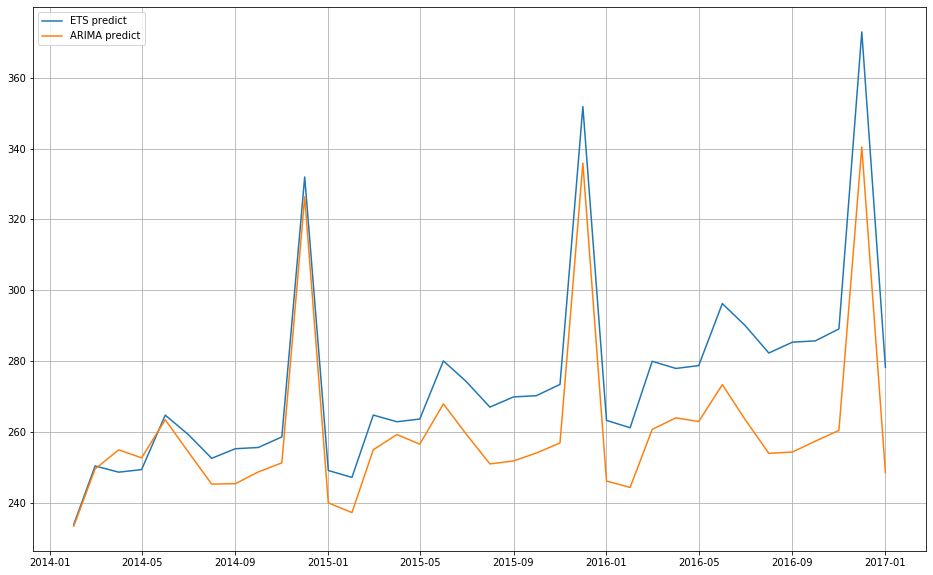

In [86]:
plt.plot(test.index, predict_ets, label = 'ETS predict')
plt.plot(test.index, model_arima_pred, label = 'ARIMA predict')
plt.legend()
plt.grid()

Остановимся на модели ARIMA, так как её остатки выглядят лучше. Воспользуемся тем, что остатки ARIMA нормальны на 1% уровне значимости, поэтому возьмем теоретические, а не бутстреп-предсказательные интервалы.

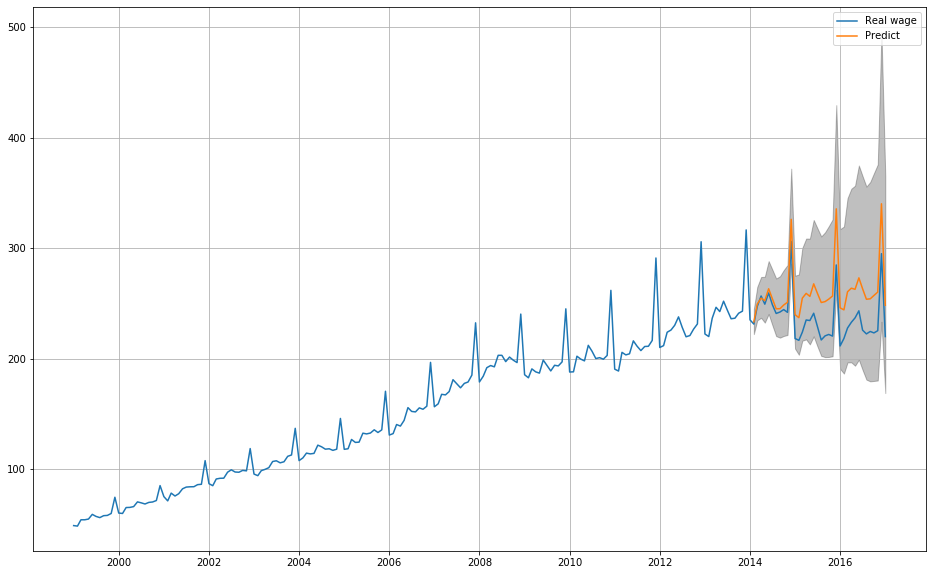

In [87]:
plt.plot(data.append(test), label='Real wage')
plt.plot(test.index, model_arima_pred, label='Predict')
plt.fill_between(test.index, arima_conf_int[:, 0], arima_conf_int[:, 1], color='k', alpha=.25)
plt.legend()
plt.grid()